Importing Libraries

In [4]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import scipy

Dataset sharding

In [3]:
# Setările directoarelor
original_data_dir = 'assets'  # Locația imaginilor originale
train_dir = 'data_split/train'
val_dir = 'data_split/val'

# Crearea directoarelor de antrenament și validare
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

classes = ['happy', 'sad', 'angry', 'relaxed']  # Stările emoționale ale câinilor

for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# Împărțirea datelor
split_ratio = 0.67
for cls in classes:
    class_dir = os.path.join(original_data_dir, cls)
    images = os.listdir(class_dir)
    random.shuffle(images)
    split_point = int(split_ratio * len(images))

    train_images = images[:split_point]
    val_images = images[split_point:]

    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_dir, cls, img))
    for img in val_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(val_dir, cls, img))


Data processing

In [5]:
# Parametrii de preprocesare
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Crearea generatorilor
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(150, 150),
                                                batch_size=32,
                                                class_mode='categorical')


Found 3600 images belonging to 4 classes.
Found 2240 images belonging to 4 classes.


CNN Model Definition

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 clase
])

Model compilation and training

In [9]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=20,
                    validation_data=val_generator)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.2663 - loss: 1.3935

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 216ms/step - accuracy: 0.2666 - loss: 1.3932 - val_accuracy: 0.3308 - val_loss: 1.3209
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.3374 - loss: 1.3098 - val_accuracy: 0.3545 - val_loss: 1.2923
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - accuracy: 0.3445 - loss: 1.2873 - val_accuracy: 0.3607 - val_loss: 1.2905
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.3496 - loss: 1.2812 - val_accuracy: 0.3402 - val_loss: 1.2847
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.3338 - loss: 1.2835 - val_accuracy: 0.3879 - val_loss: 1.2575
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.3575 - loss: 1.2679 - val_accuracy: 0.3612 - val_loss: 1.2575
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.3761 - loss: 1.2526 - val_accuracy: 0.3808 - val_loss: 1.2541
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.3782 - loss: 1.2494 - val

Results assessment

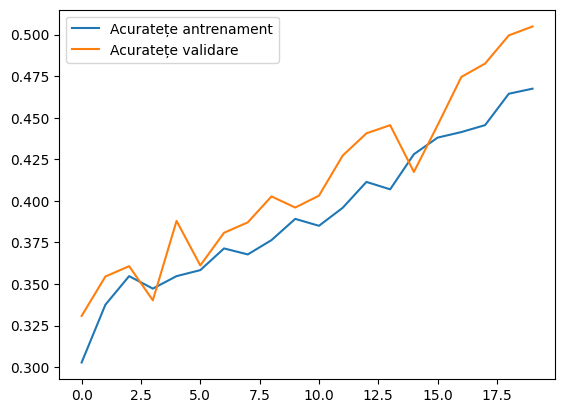

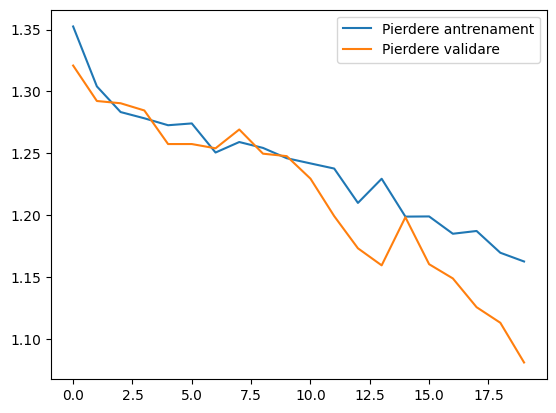

In [10]:
import matplotlib.pyplot as plt

# Acuratețea
plt.plot(history.history['accuracy'], label='Acuratețe antrenament')
plt.plot(history.history['val_accuracy'], label='Acuratețe validare')
plt.legend()
plt.show()

# Pierderea
plt.plot(history.history['loss'], label='Pierdere antrenament')
plt.plot(history.history['val_loss'], label='Pierdere validare')
plt.legend()
plt.show()

Model saving

In [14]:
model.save('models/dog_emotion_model.v1.keras')